In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp

Here, we use the mock spectrum generated by the tutorial of "Foward modeling". 

In [2]:
dat=pd.read_csv("spectrum.txt",delimiter=",",names=("wav","flux"))

We add Gaussian noise to data. nusd is the observing wavenumber grid. 

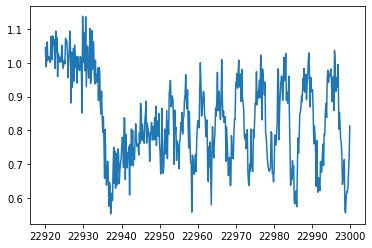

In [3]:
wavd=dat["wav"].values
flux=dat["flux"].values
nusd=jnp.array(1.e8/wavd[::-1])
sigmain=0.05
norm=40000
nflux=flux/norm+np.random.normal(0,sigmain,len(wavd))
plt.plot(wavd[::-1],nflux)


In [6]:
from exojax.spec.lpf import xsmatrix
from exojax.spec.exomol import gamma_exomol
from exojax.spec.hitran import SijT, doppler_sigma, gamma_natural, gamma_hitran
from exojax.spec.hitrancia import read_cia, logacia
from exojax.spec.rtransfer import rtrun, dtauM, dtauCIA, nugrid
from exojax.spec import planck, response
from exojax.spec.lpf import xsvector
from exojax.spec import molinfo
from exojax.utils.constants import RJ, pc, Rs, c

The model is almost same as the forward modeling, but we will infer here Rp, RV, MMR_CO, T0, alpha, and Vsini. 

In [7]:
from exojax.spec import rtransfer as rt
NP=100
Parr, dParr, k=rt.pressure_layer(NP=NP)
Nx=1500
nus,wav,res=nugrid(np.min(wavd)-5.0,np.max(wavd)+5.0,Nx,unit="AA")

R=100000.
beta=c/(2.0*np.sqrt(2.0*np.log(2.0))*R)

molmassCO=molinfo.molmass("CO")
mmw=2.33 #mean molecular weight
mmrH2=0.74
molmassH2=molinfo.molmass("H2")
vmrH2=(mmrH2*mmw/molmassH2) #VMR

Mp = 33.2 #fixing mass...

nugrid is log: mode= lpf


Loading the molecular database of CO and the CIA

In [8]:
from exojax.spec import moldb, contdb
mdbCO=moldb.MdbExomol('.database/CO/12C-16O/Li2015',nus,crit=1.e-46)
cdbH2H2=contdb.CdbCIA('.database/H2-H2_2011.cia',nus)

Background atmosphere:  H2
Reading transition file
.broad is used.
Broadening code level= a0
H2-H2


We have only 39 CO lines. 

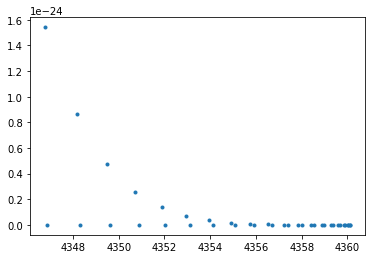

In [9]:
plt.plot(mdbCO.nu_lines,mdbCO.Sij0,".")

Again, numatrix should be precomputed prior to HMC-NUTS.

In [10]:
from exojax.spec import make_numatrix0
numatrix_CO=make_numatrix0(nus,mdbCO.nu_lines)

In [11]:
#reference pressure for a T-P model                                             
Pref=1.0 #bar
ONEARR=np.ones_like(Parr)
ONEWAV=jnp.ones_like(nflux)

In [12]:
import jax.numpy as jnp
from jax import random
from jax import vmap, jit

import numpyro.distributions as dist
import numpyro
from numpyro.infer import MCMC, NUTS
from numpyro.infer import Predictive
from numpyro.diagnostics import hpdi

Now we write the model, which is used in HMC-NUTS.

In [13]:
def model_c(nu1,y1):
    Rp = numpyro.sample('Rp', dist.Uniform(0.4,1.2))
    RV = numpyro.sample('RV', dist.Uniform(5.0,15.0))
    MMR_CO = numpyro.sample('MMR_CO', dist.Uniform(0.0,0.015))
    T0 = numpyro.sample('T0', dist.Uniform(1000.0,1500.0))
    alpha=numpyro.sample('alpha', dist.Uniform(0.05,0.2))
    vsini = numpyro.sample('vsini', dist.Uniform(15.0,25.0))
    g=2478.57730044555*Mp/Rp**2 #gravity                                        
    u1=0.0
    u2=0.0
    #T-P model//                                                                
    Tarr = T0*(Parr/Pref)**alpha

    #line computation CO                                                        
    qt_CO=vmap(mdbCO.qr_interp)(Tarr)

    def obyo(y,tag,nusd,nus,numatrix_CO,mdbCO,cdbH2H2):
        #CO                                                                     
        SijM_CO=jit(vmap(SijT,(0,None,None,None,0)))\
            (Tarr,mdbCO.logsij0,mdbCO.dev_nu_lines,mdbCO.elower,qt_CO)
        gammaLMP_CO = jit(vmap(gamma_exomol,(0,0,None,None)))\
            (Parr,Tarr,mdbCO.n_Texp,mdbCO.alpha_ref)
        gammaLMN_CO=gamma_natural(mdbCO.A)
        gammaLM_CO=gammaLMP_CO+gammaLMN_CO[None,:]
        
        sigmaDM_CO=jit(vmap(doppler_sigma,(None,0,None)))\
            (mdbCO.dev_nu_lines,Tarr,molmassCO)
        xsm_CO=xsmatrix(numatrix_CO,sigmaDM_CO,gammaLM_CO,SijM_CO)
        dtaumCO=dtauM(dParr,xsm_CO,MMR_CO*ONEARR,molmassCO,g)
        #CIA                                                                    
        dtaucH2H2=dtauCIA(nus,Tarr,Parr,dParr,vmrH2,vmrH2,\
                          mmw,g,cdbH2H2.nucia,cdbH2H2.tcia,cdbH2H2.logac)
        dtau=dtaumCO+dtaucH2H2
        sourcef = planck.piBarr(Tarr,nus)
        F0=rtrun(dtau,sourcef)/norm
        
        Frot=response.rigidrot(nus,F0,vsini,u1,u2)
        mu=response.ipgauss_sampling(nusd,nus,Frot,beta,RV)
        numpyro.sample(tag, dist.Normal(mu, sigmain), obs=y)
    
    obyo(y1,"y1",nu1,nus,numatrix_CO,mdbCO,cdbH2H2)



Run a HMC-NUTS. It took ~30min using my gaming laptop (GTX 1080 Max-Q). Here, the number of warmup is only 300, and that of the sampling is only 600, because the time when the draft on arxiv will be released is very soon (June 1st 2021 morning in JST!).

In [14]:
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)
num_warmup, num_samples = 300, 600
kernel = NUTS(model_c,forward_mode_differentiation=True)
mcmc = MCMC(kernel, num_warmup=num_warmup, num_samples=num_samples)
mcmc.run(rng_key_, nu1=nusd, y1=nflux)

sample: 100%|██████████| 900/900 [47:30<00:00,  3.63s/it, 127 steps of size 2.47e-02. acc. prob=0.93]   


Plotting a prediction and 90% area with the data... looks good.



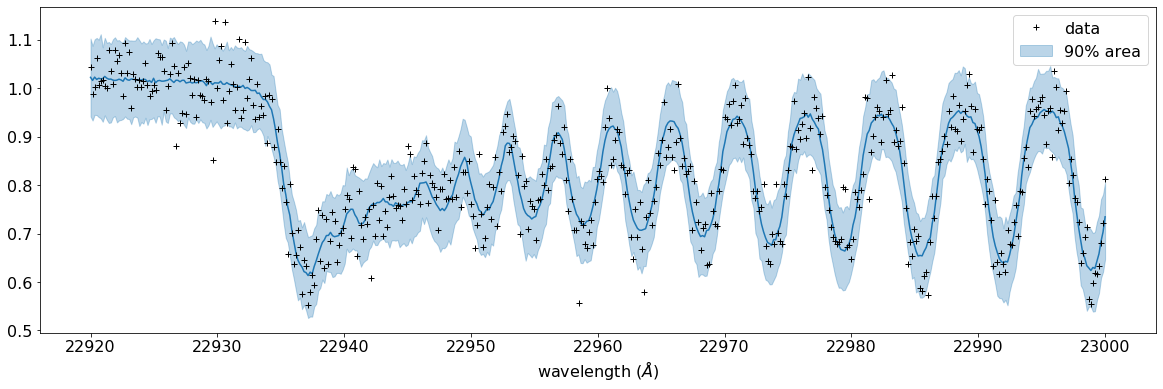

In [15]:
posterior_sample = mcmc.get_samples()
pred = Predictive(model_c,posterior_sample,return_sites=["y1"])
predictions = pred(rng_key_,nu1=nusd,y1=None)
median_mu1 = jnp.median(predictions["y1"],axis=0)
hpdi_mu1 = hpdi(predictions["y1"], 0.9)                                      
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,6.0))
ax.plot(wavd[::-1],median_mu1,color="C0")
ax.plot(wavd[::-1],nflux,"+",color="black",label="data")
ax.fill_between(wavd[::-1], hpdi_mu1[0], hpdi_mu1[1], alpha=0.3, interpolate=True,color="C0",label="90% area")
plt.xlabel("wavelength ($\AA$)",fontsize=16)
plt.legend(fontsize=16)
plt.tick_params(labelsize=16)

For the above reasons, I haven't been checking my results properly.
Arviz is useful to visualize the corner plot. Ah, the range of prior looks too narrow for some parameters. But I have no time to rerun it. Try to change the priors and run a HMC-NUTS again! The rest is up to you.

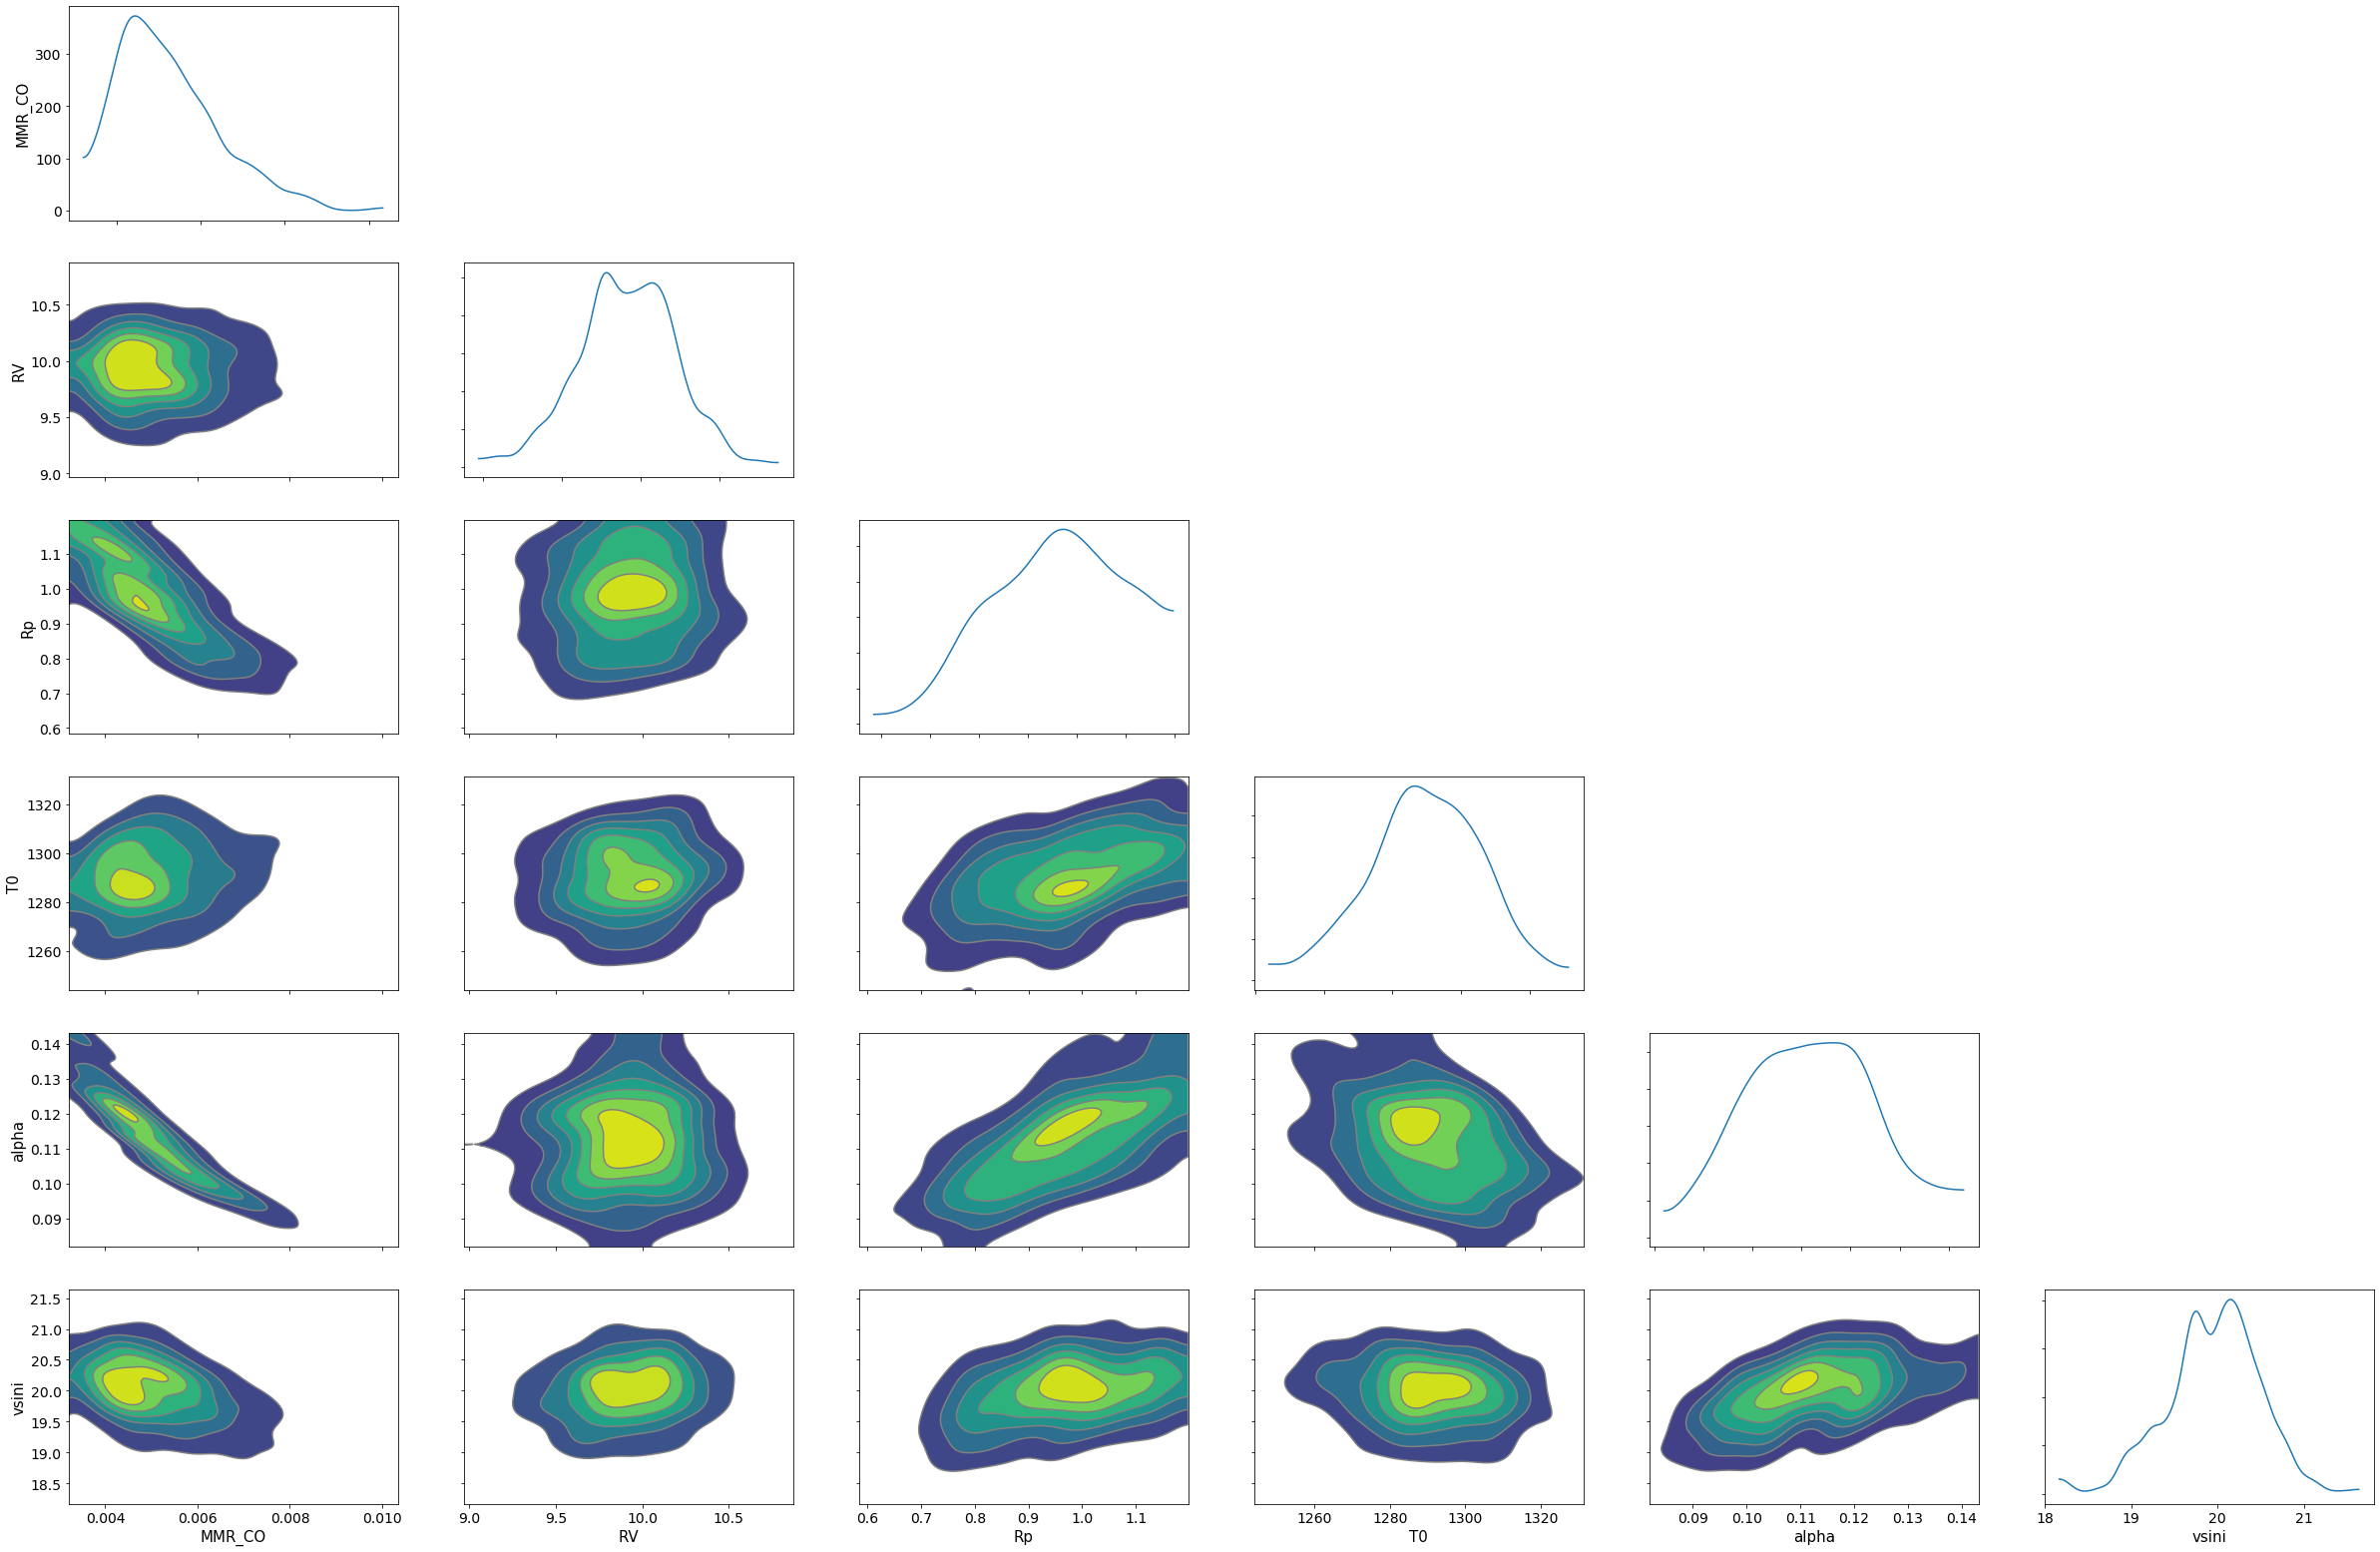

In [16]:
import arviz
pararr=["Rp","T0","alpha","MMR_CO","vsini","RV"]
arviz.plot_pair(arviz.from_numpyro(mcmc),kind='kde',divergences=False,marginals=True)
plt.show()

For fitting to the real spectrum, we may need a more well-considered model and a better GPU, such as V100 or A100. Read the next section in detail.